In [7]:
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
import warnings
from scipy.spatial.distance import euclidean

In [2]:

df_data= pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/data.csv')
df_label=pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/labels.csv')

In [3]:
df_data.drop(columns=['Unnamed: 0'],inplace=True)
df_label.drop(columns=['Unnamed: 0'],inplace=True)

In [4]:
df_label['Class'] = LabelEncoder().fit_transform(df_label['Class'])

df= df_data.join(df_label)
df

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000,4
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000,3
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000,4
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000,4
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000,0
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000,3
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693,1
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000,4


# Kmeans Clustering

In [5]:
import time
def initialize_centroids(df, k):
    """
    Function to initialize random centroids from dataset.
    Input: 
        - df: pandas dataframe with the data
        - k: integer number of clusters
    Output: 
        - temp_df: pandas dataframe with the centroids as columns and index as label
    """
    centroids = []
    for i in range(k):
        centroids.append(df.apply(lambda x: float(x.sample()))) # Take a random sample from each column to create a centroid
    centroids = pd.concat(centroids, axis=1)
    centroids.index.name = 'Label'

    return centroids


def assign_labels(df, centroids):
    """
    Function to calculate the closest centroid label for each row in a dataframe.
    Input: 
        - df: pandas dataframe with the data
        - centroids: pandas dataframe with the centroids as columns and index as label
    Output: 
        - distances.idxmin(axis=1): pandas series with the label of the closest centroid for each row in df
    """
    distances = centroids.swifter.apply(lambda x: np.sqrt(((df - x) ** 2).sum(axis=1))) # Calculate the Euclidean distance between each row in df and each centroid
    return distances.idxmin(axis=1) # Get the index of the minimum distance, which corresponds to the label of the closest centroid


def new_centroids(df_label, df1):
    """
    Function to calculate the new centroids based on the current labels of the rows.
    Input: 
        - df_label: pandas series with the label of the closest centroid for each row in df1
        - df1: pandas dataframe with the data
    Output: 
        - new_centroids.T: pandas dataframe with the new centroids as columns and index as feature name
    """
    joined_df = df1.join(df_label)
    joined_df.rename(columns={0: 'Label'}, inplace=True) # Rename the column with the label
    # Calculate the mean of the rows with the same label
    return joined_df.groupby('Label').mean().T # Transpose the dataframe to have the new centroids as columns and index as feature name


def sum_of_square_error(new_centroids, data, labels):
    """
    Computes the sum of squared errors between the data points and their assigned centroids.

    Args:
    new_centroids (DataFrame): The new centroids computed in the current iteration.
    data (DataFrame): The input data points.
    labels (DataFrame): The labels assigned to each data point.

    Returns:
    The sum of squared errors.
    """
    # Transpose the new centroids dataframe and reset the index
    new_centroids = new_centroids.T.reset_index()
    # Get the columns of the data dataframe
    columns = data.columns
    # Join the data dataframe and the labels dataframe
    data = data.join(labels)
    # Rename the '0' column of the labels dataframe to 'Label'
    data.rename(columns={0:'Label'}, inplace=True)
    sse = []
    # Compute the distance between each data point and its assigned centroid
    for i in range(len(new_centroids)):
        distance = np.sum(np.square(data[data['Label']==i][columns] - new_centroids.iloc[i][columns]), axis=1)
        sse.append(sum(distance))
    # Return the sum of squared errors
    return sum(sse)   

def kmeans_lyod_with_error(df1, k, tou):
    """
    Function to run the K-means Lloyd algorithm.
    Input: 
        - df1: pandas dataframe with the data
        - k: integer number of clusters
        - tou: float tolerance level to stop the algorithm
    Output: 
        - centroids: pandas dataframe with the final centroids as columns and index as label
    """
    start_time=time.time()
    centroids = initialize_centroids(df1, k) # Initialize random centroids
    initial_list_of_columns = centroids.columns.to_list()
    iteration = 0
    while True:
        # Assign labels to current centroids
        df_label = assign_labels(df1, centroids)
        df_label = pd.DataFrame(df_label)
        # Calculate new centroids
        df_new_centroids = new_centroids(df_label, df1)
        new_list_of_columns = df_new_centroids.columns.to_list()
        # Keep the number of clusters the same i.e maintain same k
        for i in initial_list_of_columns:
            if i not in new_list_of_columns:
                df_new_centroids[i] = centroids[i]
        # Calculate tao
        distance = []
        for col in centroids.columns:
            col_distance = euclidean(centroids[col], df_new_centroids[col])
            distance.append(col_distance)
        tao_calculated=sum(distance)/k #Used the formula provided for calculating Tao
        sse = sum_of_square_error(df_new_centroids, df1, df_label)
        #error=error_clusters(df_label,df1,k)
        end_time= time.time()
        if iteration>100:  
            print("Iteration exceeded")

            return  sse,end_time-start_time
            break
            
        if tao_calculated<tou or iteration >100:   #if the convergence is met, kmeans will stop  or else if the convergence is never met, after 100 iteration code will stop 
            return  sse,end_time-start_time
            break                                   # otherwise indefinite loop
        else:
            centroids= df_new_centroids # In case we need more iterations, the centroids calculated at this step acts as input
        iteration+=1



# Applying Kmeans Clustering on complete data, before PCA

In [9]:
error_matrix=[]
for i in range (1,21):
    sse,run_time=kmeans_lyod_with_error(df,5,10)
    error_matrix.append([i,sse,run_time])
error_matrix_df= pd.DataFrame(error_matrix,columns=[ 'repetition','sse','run_time'])  
error_matrix_df


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

,repetition,sse,run_time
0,1,1.785455e+07,102.876694
1,2,2.039526e+07,124.035076
2,3,1.790664e+07,80.721551
3,4,2.025279e+07,78.436528
4,5,2.117784e+07,100.116819
5,6,1.912287e+07,99.549704
6,7,1.897678e+07,142.760602
7,8,1.905893e+07,101.825637
8,9,1.972102e+07,145.136663
9,10,1.957713e+07,101.950491


In [ ]:
# df_kmeans= pd.DataFrame(np.real(principal_component.values), columns=principal_component.columns)

# # Using label encoding to convert string class to numeric
# df_label['Class'] = LabelEncoder().fit_transform(df_label['Class'])

# df_kmeans= df_kmeans.join(df_label)
# df_kmeans

In [10]:
error_matrix_df.to_csv('kmeans_hw5_alldata.csv',index=False)



# Applying Kmeans Clustering after PCA

In [17]:
### After clustering

principal_component=pd.read_csv('principal_component.csv')
principal_component=principal_component.join(df_label)
principal_component

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC364,PC365,PC366,PC367,PC368,PC369,PC370,PC371,PC372,Class
0,57.446987,95.410981,-74.301543,-12.166781,-7.981831,-36.157573,-7.668542,-19.951444,0.142216,-3.035240,...,-1.761114,2.821183,-1.787594,-2.698708,-2.518873,-2.006253,1.385627,-0.075669,-0.668623,4
1,16.919430,0.732470,64.072900,-2.095308,25.426430,-27.784178,-16.132765,17.031383,-22.023874,27.923308,...,4.840131,2.988708,-1.029549,2.092449,-1.647998,6.208070,2.046062,0.890695,0.578969,3
2,70.345218,-19.303327,-20.488240,48.102893,-24.437757,-17.462510,20.706772,47.626817,-28.647648,12.784676,...,1.084395,0.402993,-0.700511,-1.315347,5.013460,2.119968,1.704379,-0.776193,3.447188,4
3,49.161591,-9.227586,-61.243770,37.805744,-1.038889,-23.240002,-4.801039,21.554809,-15.375067,12.881511,...,0.505183,-3.890712,-0.458207,1.903958,0.697658,-2.893746,0.209234,3.109684,0.922602,4
4,18.132534,-51.327797,-16.598116,-17.699201,-26.389130,1.551573,-6.266101,-12.336677,-4.233837,-28.804476,...,1.774446,2.722033,0.116283,-1.694152,3.238688,-0.653246,-1.020225,3.150149,-0.974301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,12.417385,-42.321573,-28.109566,-31.200320,-38.814556,-2.762444,-15.524261,-10.618692,8.528240,-27.573714,...,-0.183957,1.520214,1.413367,1.273846,-1.517010,-0.767866,1.470709,-1.689902,3.233389,0
797,29.415554,28.526281,15.956631,-11.635178,37.071404,16.239422,-17.341039,35.107458,-26.870257,-31.147205,...,-3.082539,1.723200,2.102350,0.279098,1.050980,0.366196,-4.177639,-1.295355,-1.772439,3
798,4.133090,15.690014,22.644453,-11.982424,57.835783,39.652668,47.718063,-24.221214,22.709097,32.888886,...,-0.383244,-0.978894,-1.402018,1.508294,-0.079742,0.492916,0.129879,0.848905,-0.004379,1
799,30.814757,33.526423,-70.565636,16.643656,16.579983,4.318571,20.482607,9.552721,3.680009,7.948784,...,3.989814,0.135392,-1.916288,-1.899100,-0.617998,1.303425,-0.680783,-2.558321,1.181467,4


In [18]:
error_matrix=[]
for i in range (1,21):
    sse,run_time=kmeans_lyod_with_error(principal_component,5,10)
    error_matrix.append([i,sse,run_time])
error_matrix_df_pca= pd.DataFrame(error_matrix,columns=[ 'repetition','sse','run_time'])  
error_matrix_df_pca.to_csv('error_matrix_df_pca.csv')


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
error_matrix_df_pca['sse'].mean()

11465730.680092001

In [22]:
error_matrix_df['sse'].mean()

19045435.84364903

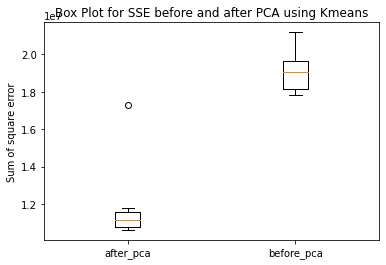

In [28]:
combined_df = pd.concat([error_matrix_df_pca, error_matrix_df], keys=['after_pca', 'before_pca'])

# create the boxplot
plt.boxplot([combined_df.loc['after_pca']['sse'], combined_df.loc['before_pca']['sse']])
plt.xticks([1, 2], ['after_pca', 'before_pca'])
plt.ylabel('Sum of square error')
plt.title('Box Plot for SSE before and after PCA using Kmeans')
plt.show()